# 1. Use SAM for Image Segmentation
# 2. Use Pose Detection to find the pose of the person
# 3. Segment Diffrent parts of the body

In [1]:
import torch
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import cv2

/home/sampurn/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Code from segment anything documentation

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=lambda x: x['area'], reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = color_mask[i]
        ax.imshow(np.dstack((img, m * 0.35)))

#### Setting up SAM

In [2]:

sam_checkpoint = "../resources/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type] (checkpoint=sam_checkpoint)
sam.to (device=device)
print()

In [ ]:
image = cv2.imread('../preprocessed-data/good_ankle/9.jpg')
image = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)


mask_generator = SamAutomaticMaskGenerator (sam)
masks = mask_generator.generate(image)
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns (masks)
plt.axis ('off')
plt.show()

#### Setting object tracker from YOLO - NAS


[ A for loop in this one will do the job]

In [3]:
import sys
sys.path.append("..")
from super_gradients.training import models
from segment_anything import  SamPredictor
import numpy as np
import cv2

[2023-07-16 17:17:14] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/sampurn/sg_logs/console.log


[2023-07-16 17:17:16] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-07-16 17:17:16] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-07-16 17:17:16] WARNING - export.py - Failed to import pytorch_quantization
[2023-07-16 17:17:16] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


#### Setting parameters

In [4]:
model = models.get("yolo_nas_l", pretrained_weights="coco")
conf_threshold = 0.6

# more independed parts here


[2023-07-16 17:17:18] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


In [5]:
image_path = "../preprocessed-data/good_ankle/9.jpg"
detection_pred = model.predict(image_path, conf = conf_threshold)._images_prediction_lst

# Convert generator to a list
detection_list = list(detection_pred)

# Extract desired outputs
bboxes_xyxy = detection_list[0].prediction.bboxes_xyxy.tolist()
confidence = detection_list[0].prediction.confidence.tolist()
labels = detection_list[0].prediction.labels.tolist()

# Print the results
print("Bounding Boxes (xyxy):", bboxes_xyxy)
print("Confidence:", confidence)
print("Labels:", labels)


Bounding Boxes (xyxy): [[4.243253707885742, 5.194187164306641, 309.366943359375, 1322.751953125]]
Confidence: [0.9779171943664551]
Labels: [0.0]


In [11]:

predictor = SamPredictor(sam) # Initialize the predictor


image = cv2.imread(image_path)

predictor.set_image(image)


image = image.transpose((2, 0, 1))  # Transpose to match SAM input format
image = image / 255.0  # Normalize image values to [0, 1]
image = np.expand_dims(image, axis=0)  # Add batch dimension

input_box = np.array(bboxes_xyxy[0])
if labels[0] == 0:
    # Predict masks using SAM
    masks, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=False,
    )

# Display the image with masks and bounding box


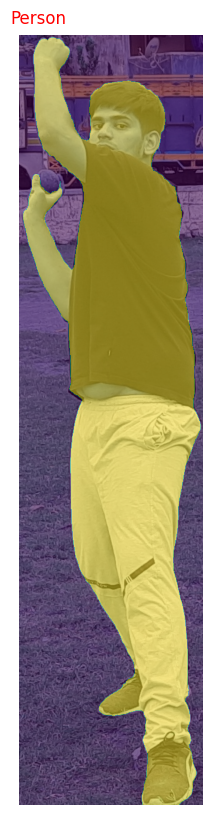

In [12]:
padding = 20  # Adjust this value as needed
input_box[0] -= padding  # Decrease xmin
input_box[1] -= padding  # Decrease ymin
input_box[2] += padding  # Increase xmax
input_box[3] += padding  # Increase ymax

# Display the image with masks and bounding box
plt.figure(figsize=(10, 10))
plt.imshow(image[0].transpose((1, 2, 0)))
if labels[0] == 0:
    plt.imshow(masks[0], alpha=0.5)
    plt.gca().add_patch(plt.Rectangle((input_box[0], input_box[1]), input_box[2] - input_box[0], input_box[3] - input_box[1],
                                      linewidth=2, edgecolor='r', facecolor='none'))
plt.text(input_box[0], input_box[1] - 5, 'Person', fontsize=12, color='r', backgroundcolor='w')
plt.axis('off')
# plt.savefig('output_folder/output3.png')
plt.show()

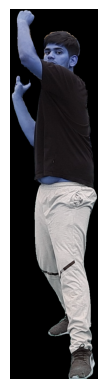

In [13]:
# make background black and mask person
masked_image = cv2.bitwise_and(image[0].transpose((1, 2, 0)), image[0].transpose((1, 2, 0)), mask=masks[0].astype(np.uint8))

plt.imshow(masked_image)
plt.axis('off')
plt.show()

# Segmenter class code

In [11]:
from super_gradients.training import models
import matplotlib.pyplot as plt
import cv2

class DetectBuddy():
    
    def __init__(self,model_name='yolo_nas_l',weights='coco',conf_threshold=0.8):
        self.model = models.get(model_name, pretrained_weights=weights)
        self.conf_threshold=conf_threshold
        self.detection_list=[]
        
    def predict_human(self,image_path,show=False):
        
        prediction = self.model.predict(image_path, conf=self.conf_threshold)
        if show:
            prediction.show()
        
        detection_pred = prediction._images_prediction_lst
        self.detection_list = list(detection_pred)
        
    
    
    def predict_human(self,image,show=False):
        prediction = self.model.predict(image, conf=self.conf_threshold)
        if show:
            prediction.show()
        
        detection_pred = prediction._images_prediction_lst
        self.detection_list = list(detection_pred)
        
    

In [12]:
detect=DetectBuddy()

[2023-07-16 17:24:53] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


In [30]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

import sys
sys.path.append("..")
from super_gradients.training import models
from segment_anything import  SamPredictor
import numpy as np
import cv2



class SegmentBuddy():
    
    ##### CODE FROM DOCUMENTATION #####
    def show_mask(mask, ax, random_color=False):
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        else:
            color = np.array([30/255, 144/255, 255/255, 0.6])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)

    def show_points(coords, labels, ax, marker_size=375):
        pos_points = coords[labels==1]
        neg_points = coords[labels==0]
        ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
        ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

    def show_box(box, ax):
        x0, y0 = box[0], box[1]
        w, h = box[2] - box[0], box[3] - box[1]
        ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

    def show_anns(anns):
        if len(anns) == 0:
            return
        sorted_anns = sorted(anns, key=lambda x: x['area'], reverse=True)
        ax = plt.gca()
        ax.set_autoscale_on(False)
        polygons = []
        for ann in sorted_anns:
            m = ann['segmentation']
            img = np.ones((m.shape[0], m.shape[1], 3))
            color_mask = np.random.random((1, 3)).tolist()[0]
            for i in range(3):
                img[:, :, i] = color_mask[i]
            ax.imshow(np.dstack((img, m * 0.35)))
            
    ##### CODE FROM DOCUMENTATION #####
    
    
    
    def __init__(self,path_to_checkpoints, model_type="vit_h",device="cuda" if torch.cuda.is_available() else "cpu"):
        
        self.sam = sam_model_registry[model_type] (checkpoint=path_to_checkpoints)
        self.sam.to (device=device)
        
        self.mask_generator = SamAutomaticMaskGenerator (self.sam)
        
        self.predictor = SamPredictor(self.sam)
            
            
    def segment_person(self,image_path,show_mask=False):
        
        
        detect.predict_human(image_path)

        
        detection_list = detect.detection_list

        
        bboxes_xyxy = detection_list[0].prediction.bboxes_xyxy.tolist()
        labels = detection_list[0].prediction.labels.tolist()
        
        image = cv2.imread(image_path)
        
        masks = self.mask_generator.generate(image)

        self.predictor.set_image(image)

        image = image.transpose((2, 0, 1))  # Transpose to match SAM input format
        image = image / 255.0  # Normalize image values to [0, 1]
        image = np.expand_dims(image, axis=0)  # Add batch dimension
        input_box = np.array(bboxes_xyxy[0])
        
        if labels[0] == 0:
           
            masks, _, _ = self.predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_box[None, :],
                multimask_output=False,
            )
    
        masked_image = cv2.bitwise_and(image[0].transpose((1, 2, 0)), image[0].transpose((1, 2, 0)), mask=masks[0].astype(np.uint8))
        
        
        if show_mask:
            plt.imshow(image[0].transpose((1, 2, 0)))
            if labels[0] == 0:
                plt.imshow(masks[0], alpha=0.5)
                
       
        plt.imshow(masked_image)
        plt.axis('off')
        plt.show()
        return masked_image
        
        

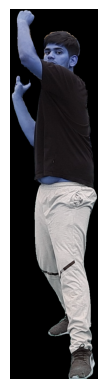

In [31]:

segmentor=SegmentBuddy("../resources/sam_vit_h_4b8939.pth")

masked_image=segmentor.segment_person("../preprocessed-data/good_ankle/9.jpg")

# Extractor class code

In [3]:

director=DirectoryBuddy("../preprocessed-data")

image_dict=director.create_image_array(show=False)





NameError: name 'DirectoryBuddy' is not defined